In [1]:
# REINFORCE, VPG, A3C, GAE, A2C

In [2]:
# import warnings ; warnings.filterwarnings('ignore')

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=""
os.environ['OMP_NUM_THREADS'] = '1'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
from itertools import cycle, count
from textwrap import wrap

import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import time
import json
import sys
import gym
import io
import os

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

try:
    mp.set_start_method('fork')
except RuntimeError:
    pass

assert not torch.cuda.is_available()

ERASE_LINE = '\x1b[2K'
EPS = 1e-6
PRINT_EVERY_SEC = 20

plt.style.use('fivethirtyeight')
np.set_printoptions(suppress=True)
%matplotlib inline

In [3]:
def get_make_env_fn(**kargs):
    def make_env_fn(env_name, seed=None, unwrapped=False, monitor_mode=None, addon_wrappers=None):
        #print('env_name {}, seed {}, unwrapped {}, monitor_mode {}, wrappers {}'.format(
        #    env_name, seed, unwrapped, monitor_mode, wrappers))
        mdir = tempfile.mkdtemp()
        env = gym.make(env_name)
        if seed is not None: env.seed(seed)
        env = env.unwrapped if unwrapped else env
        env = wrappers.Monitor(env, mdir, force=True, mode=monitor_mode) if monitor_mode else env
        if addon_wrappers:
            for wrapper in addon_wrappers:
                env = wrapper(env)
        return env
    return make_env_fn, kargs

In [4]:
def plot_results(results, log_scale=False):
    plt.figure(figsize=(15, 10))
    lines = ["-","--",":","-."]
    linecycler = cycle(lines)
    for experiment, experiment_name, env in results:
        label = '\n'.join(wrap(experiment_name.replace('_', ', '), 50))
        plt.plot(experiment, next(linecycler), label=label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if log_scale: plt.xscale('log')
    plt.ylabel('Rewards')
    plt.xlabel('Episode')
    plt.show()

In [5]:
def get_videos_html(env_videos, title, max_n_videos=5):
    videos = np.array(env_videos)
    if len(videos) == 0:
        return
    
    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        video = io.open(video_path, 'r+b').read()
        encoded = base64.b64encode(video)

        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <video width="960" height="540" controls>
            <source src="data:video/mp4;base64,{1}" type="video/mp4" />
        </video>"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [6]:
def get_gif_html(env_videos, title, max_n_videos=5):
    videos = np.array(env_videos)
    if len(videos) == 0:
        return
    
    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        basename = os.path.splitext(video_path)[0]
        gif_path = basename + '.gif'
        if not os.path.exists(gif_path):
            ps = subprocess.Popen(
                ('ffmpeg', 
                 '-i', video_path, 
                 '-r', '10', 
                 '-f', 'image2pipe', 
                 '-vcodec', 'ppm', 
                 '-'), 
                stdout=subprocess.PIPE)
            output = subprocess.check_output(
                ('convert', 
                 '-delay', '5', 
                 '-loop', '0', 
                 '-', gif_path), 
                stdin=ps.stdout)
            ps.wait()

        gif = io.open(gif_path, 'r+b').read()
        encoded = base64.b64encode(gif)
            
        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <img src="data:image/gif;base64,{1}" />"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [7]:
class DiscountedCartPole(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)
    def step(self, a):
        o, r, d, _ = self.env.step(a)
        (x, x_dot, theta, theta_dot) = o
        pole_fell =  x < -self.env.unwrapped.x_threshold \
                    or x > self.env.unwrapped.x_threshold \
                    or theta < -self.env.unwrapped.theta_threshold_radians \
                    or theta > self.env.unwrapped.theta_threshold_radians
        r = -1 if pole_fell else 0
        return o, r, d, _

In [8]:
class MCCartPole(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)
    def step(self, a):
        o, r, d, _ = self.env.step(a)
        (x, x_dot, theta, theta_dot) = o
        pole_fell =  x < -self.env.unwrapped.x_threshold \
                    or x > self.env.unwrapped.x_threshold \
                    or theta < -self.env.unwrapped.theta_threshold_radians \
                    or theta > self.env.unwrapped.theta_threshold_radians
        if d:
            if pole_fell:
                r = 0 # done, in failure
            else:
                r = self.env._max_episode_steps # done, but successfully
        return o, r, d, _

# Monte-Carlo REINFORCE

In [9]:
class FCDP(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim,
                 hidden_dims=(32,32), 
                 init_weight=0.003,
                 activation_fc=F.relu):
        super(FCDP, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, 
                                     hidden_dims[0])
        
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(
                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
                
        self.output_layer = nn.Linear(
            hidden_dims[-1], output_dim)
        
        self.output_layer.weight.data.uniform_(
            -init_weight, init_weight)
        self.output_layer.bias.data.uniform_(
            -init_weight, init_weight)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        return self.output_layer(x)

    def select_action(self, state):
        logits = self.forward(state)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        logpa = dist.log_prob(action).unsqueeze(-1)
        entropy = dist.entropy().unsqueeze(-1)
        return action.item(), logpa, entropy

In [10]:
class REINFORCE():
    def __init__(self, policy_model_fn, policy_model_max_grad_norm, 
                 policy_optimizer_fn, policy_optimizer_lr, 
                 entropy_loss_weight):
        self.policy_model_fn = policy_model_fn
        self.policy_model_max_grad_norm = policy_model_max_grad_norm
        self.policy_optimizer_fn = policy_optimizer_fn
        self.policy_optimizer_lr = policy_optimizer_lr
        self.entropy_loss_weight = entropy_loss_weight

    def optimize_model(self):
        T = len(self.rewards)
        discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)
        returns = np.array([np.sum(discounts[:T-t] * self.rewards[t:]) for t in range(T)])
        # returns = (returns - returns.mean()) / (returns.std() + EPS)

        discounts = torch.FloatTensor(discounts).unsqueeze(1)
        returns = torch.FloatTensor(returns).unsqueeze(1)
        self.logpas = torch.cat(self.logpas)
        self.entropies = torch.cat(self.entropies)
        
        policy_loss = -(discounts * returns * self.logpas).mean()
        entropy_loss = -(self.entropy_loss_weight * self.entropies).mean()
        loss = policy_loss + entropy_loss

        self.policy_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), 
                                       self.policy_model_max_grad_norm)
        self.policy_optimizer.step()

    def interaction_step(self, state, env):
        action, logpa, entropy = self.policy_model.select_action(state)
        new_state, reward, is_terminal, _ = env.step(action)

        self.logpas.append(logpa)
        self.entropies.append(entropy)
        self.rewards.append(reward)
        
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        
        return new_state, is_terminal

    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)
    
        nS, nA = env.observation_space.shape[0], env.action_space.n
        self.episode_exploration = []
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []
        
        self.policy_model = self.policy_model_fn(nS, nA)
        self.policy_optimizer = self.policy_optimizer_fn(self.policy_model, 
                                                         self.policy_optimizer_lr)
        result = np.empty((max_episodes, 4))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            # collect rollout
            self.logpas, self.entropies, self.rewards = [], [], []
            for step in count():
                state, is_terminal = self.interaction_step(state, env)
                if is_terminal:
                    break
            self.optimize_model()

            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.policy_model, env)
            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            sec_per_ep = np.mean(self.episode_seconds)
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            result[episode-1] = total_step, training_time, mean_100_reward, mean_100_eval_score
            
            reached_debug_time = time.time() - last_debug_time >= PRINT_EVERY_SEC
            reached_max_minutes = time.time() - training_start >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
            elapsed_str = time.strftime("%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'elp {}, ep {:04}, stps {:06}, s/ep {:.3f}, '
            debug_message += u'av r - lst10 {:06.2f}\u00B1{:06.2f} - lst100 {:06.2f}\u00B1{:06.2f}, '
            debug_message += 'eval {:06.2f}\u00B1{:06.2f}'
            debug_message = debug_message.format(
                elapsed_str, episode, total_step, sec_per_ep, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_eval_score, std_100_eval_score)
            print(debug_message, end="\r")
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break

        final_eval_score, score_std = self.evaluate(self.policy_model, env, n_episodes=100)
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time.\n'.format(
            final_eval_score, score_std, training_time))
        env.close()
        del env
        return result, final_eval_score, training_time

    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                a, _, _ = eval_policy_model.select_action(s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)
    
    def demo(self, title='Trained REINFORCE Agent', n_episodes=10, max_n_videos=3):        
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation')
        self.evaluate(self.policy_model, env, n_episodes=n_episodes)
        env.close()
        data = get_gif_html(env_videos=env.videos, title=title, max_n_videos=max_n_videos)
        return HTML(data=data)

In [11]:
reinforce_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in [12, 34, 56 , 78, 90]:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 1.00,
        'max_minutes': 5,
        'max_episodes': 5000,
        'goal_mean_100_reward': 195
    }

    policy_model_fn = lambda nS, nA: FCDP(nS, nA, hidden_dims=(256,256))
    policy_model_max_grad_norm = 25
    policy_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.0005
    entropy_loss_weight = 0.0001

    env_name, gamma, max_minutes, max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = REINFORCE(policy_model_fn, policy_model_max_grad_norm, 
                      policy_optimizer_fn, policy_optimizer_lr, 
                      entropy_loss_weight)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    # make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name, unwrapped=True)
    # make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name, addon_wrappers=[MCCartPole,])
    result, final_eval_score, training_time = agent.train(make_env_fn, make_env_kargs, 
                                                          seed, gamma, 
                                                          max_minutes, max_episodes, 
                                                          goal_mean_100_reward)
    reinforce_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
reinforce_results = np.array(reinforce_results)

/opt/conda/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


elp 00:00, ep 0001, stps 000019, s/ep 0.051, av r - lst10 019.00±000.00 - lst100 019.00±000.00, eval 013.00±000.00
elp 00:20, ep 0323, stps 023834, s/ep 0.044, av r - lst10 076.90±052.23 - lst100 135.65±077.66, eval 139.64±074.26
elp 00:40, ep 0521, stps 048408, s/ep 0.055, av r - lst10 181.20±013.76 - lst100 161.54±043.74, eval 164.38±045.79
elp 01:00, ep 0692, stps 073580, s/ep 0.062, av r - lst10 305.00±095.68 - lst100 166.21±060.96, eval 168.35±075.45
elp 01:03, ep 0702, stps 078407, s/ep 0.064, av r - lst10 482.70±034.69 - lst100 201.28±111.80, eval 196.69±111.03
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score 425.80±60.96 in 45.08s training time.

elp 00:00, ep 0001, stps 000020, s/ep 0.012, av r - lst10 020.00±000.00 - lst100 020.00±000.00, eval 011.00±000.00
elp 00:20, ep 0285, stps 023543, s/ep 0.050, av r - lst10 157.10±049.44 - lst100 151.86±061.64, eval 150.84±071.09
elp 00:40, ep 0546, stps 046569, s/ep 0.051, av r - lst10 094.70±040.94 - lst100 07


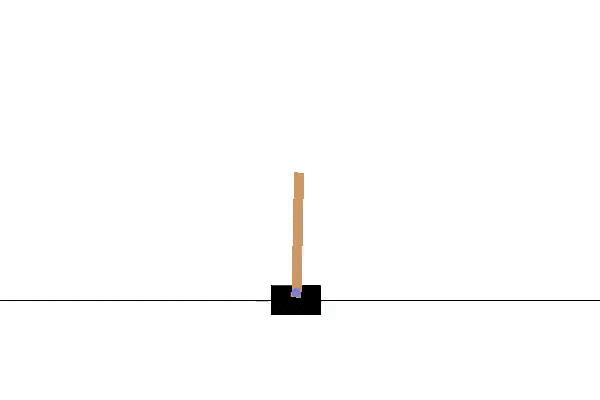
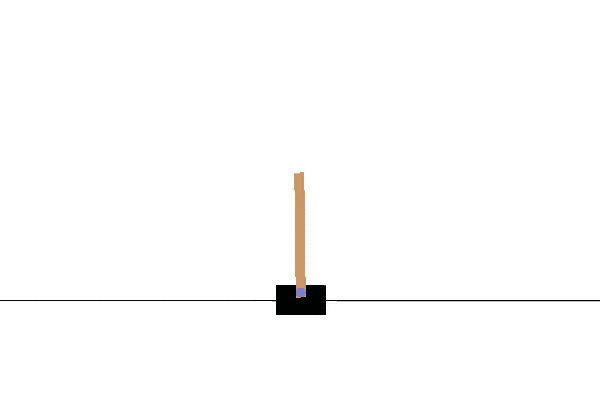
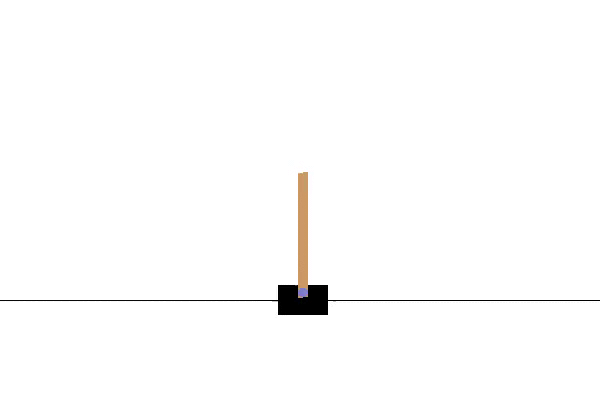

In [12]:
best_agent.demo()

In [13]:
reinforce_max_t, reinforce_max_sec, reinforce_max_r, reinforce_max_s = np.max(reinforce_results, axis=0).T
reinforce_min_t, reinforce_min_sec, reinforce_min_r, reinforce_min_s = np.min(reinforce_results, axis=0).T
reinforce_mean_t, reinforce_mean_sec, reinforce_mean_r, reinforce_mean_s = np.mean(reinforce_results, axis=0).T
reinforce_x = np.arange(len(reinforce_mean_s))

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


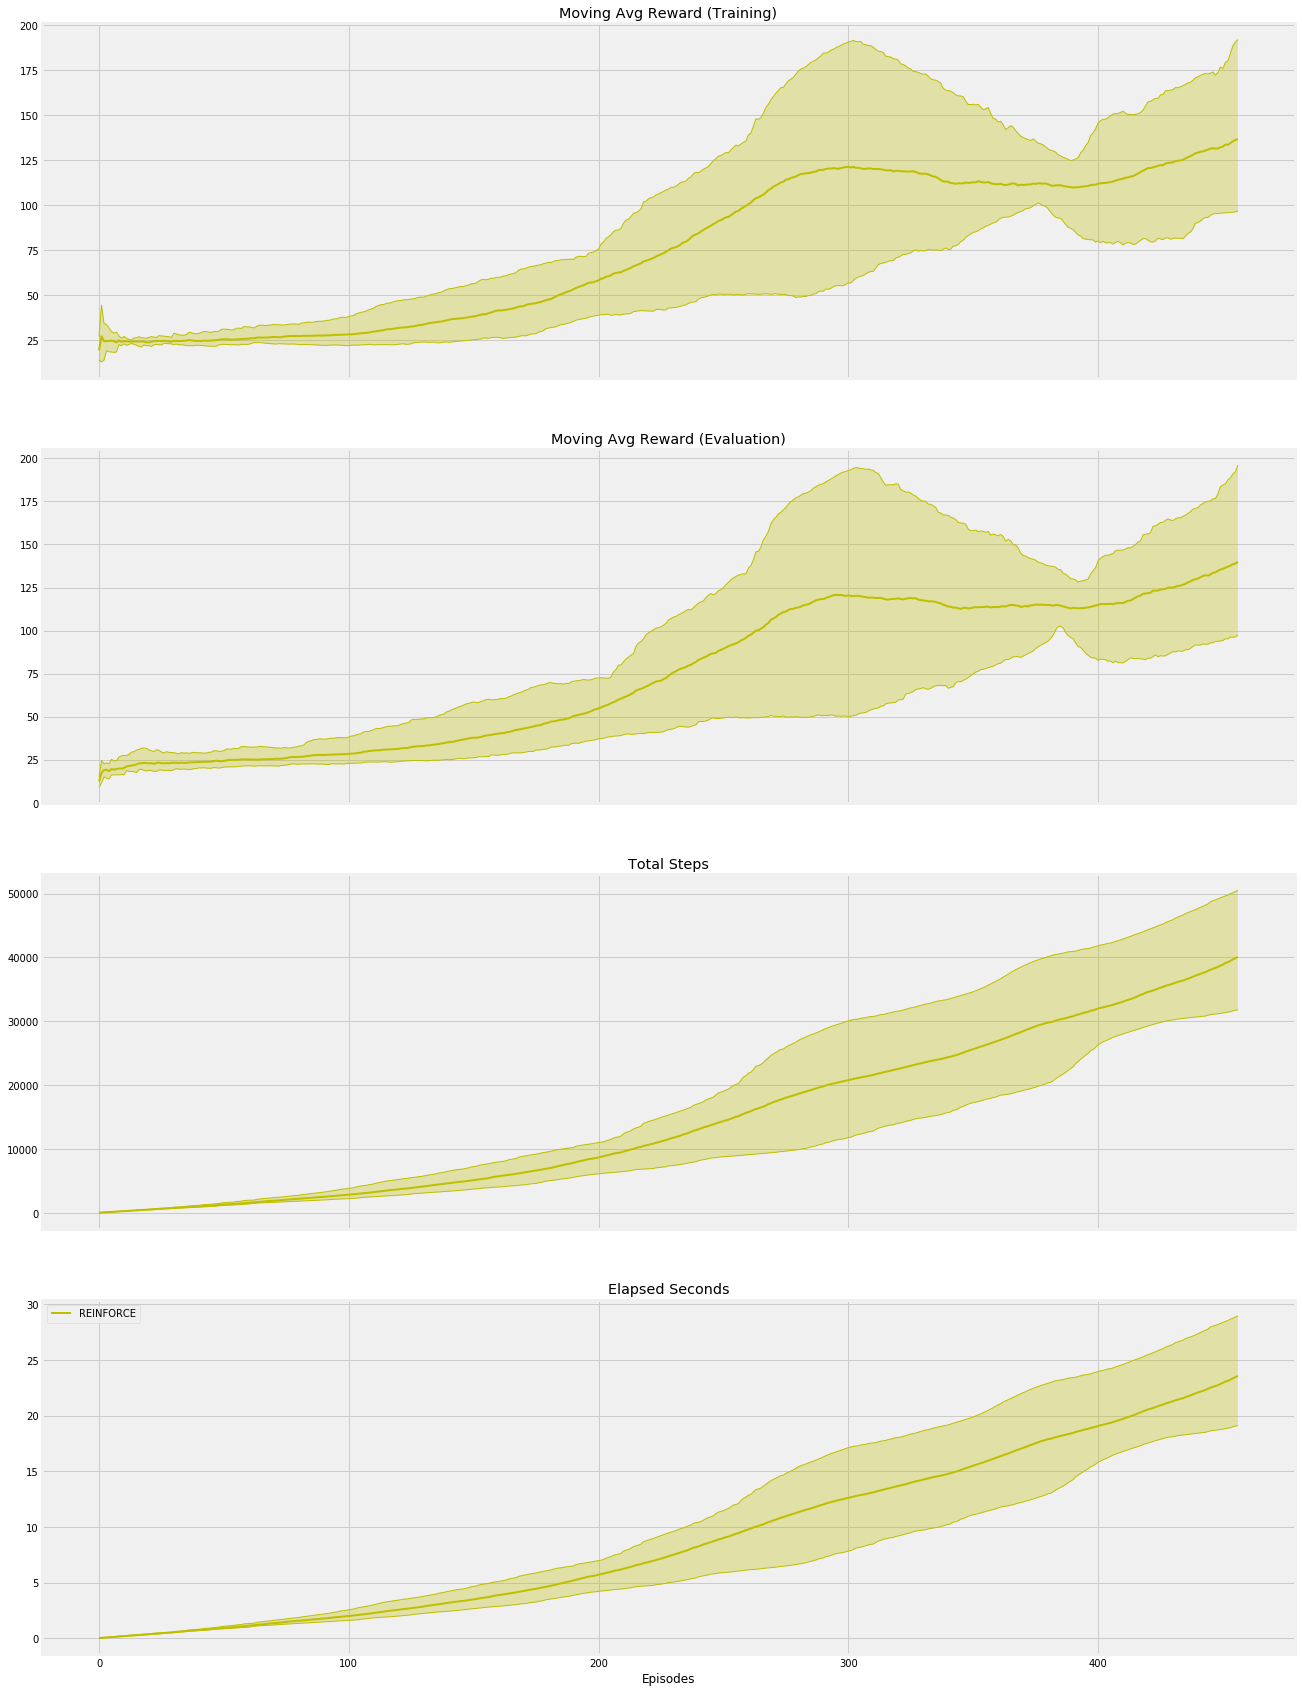

In [14]:
fig, axs = plt.subplots(4, 1, figsize=(20,30), sharey=False, sharex=True)

# REINFORCE
axs[0].plot(reinforce_max_r, 'y', linewidth=1)
axs[0].plot(reinforce_min_r, 'y', linewidth=1)
axs[0].plot(reinforce_mean_r, 'y', label='REINFORCE', linewidth=2)
axs[0].fill_between(reinforce_x, reinforce_min_r, reinforce_max_r, facecolor='y', alpha=0.3)

axs[1].plot(reinforce_max_s, 'y', linewidth=1)
axs[1].plot(reinforce_min_s, 'y', linewidth=1)
axs[1].plot(reinforce_mean_s, 'y', label='REINFORCE', linewidth=2)
axs[1].fill_between(reinforce_x, reinforce_min_s, reinforce_max_s, facecolor='y', alpha=0.3)

axs[2].plot(reinforce_max_t, 'y', linewidth=1)
axs[2].plot(reinforce_min_t, 'y', linewidth=1)
axs[2].plot(reinforce_mean_t, 'y', label='REINFORCE', linewidth=2)
axs[2].fill_between(reinforce_x, reinforce_min_t, reinforce_max_t, facecolor='y', alpha=0.3)

axs[3].plot(reinforce_max_sec, 'y', linewidth=1)
axs[3].plot(reinforce_min_sec, 'y', linewidth=1)
axs[3].plot(reinforce_mean_sec, 'y', label='REINFORCE', linewidth=2)
axs[3].fill_between(reinforce_x, reinforce_min_sec, reinforce_max_sec, facecolor='y', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Elapsed Seconds')
plt.xlabel('Episodes')
plt.legend()
plt.show()

# Monte-Carlo VPG

In [15]:
class FCV(nn.Module):
    def __init__(self, 
                 input_dim,
                 hidden_dims=(32,32), 
                 init_weight=0.003,
                 activation_fc=F.relu):
        super(FCV, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, 
                                     hidden_dims[0])
        
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(
                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)

        self.output_layer = nn.Linear(
            hidden_dims[-1], 1)
        
        self.output_layer.weight.data.uniform_(
            -init_weight, init_weight)
        self.output_layer.bias.data.uniform_(
            -init_weight, init_weight)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x,
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        return self.output_layer(x)

In [16]:
class VPG():
    def __init__(self, policy_model_fn, policy_model_max_grad_norm, policy_optimizer_fn, policy_optimizer_lr,
                 value_model_fn, value_model_max_grad_norm, value_optimizer_fn, value_optimizer_lr, 
                 entropy_loss_weight):
        self.policy_model_fn = policy_model_fn
        self.policy_model_max_grad_norm = policy_model_max_grad_norm
        self.policy_optimizer_fn = policy_optimizer_fn
        self.policy_optimizer_lr = policy_optimizer_lr
        
        self.value_model_fn = value_model_fn
        self.value_model_max_grad_norm = value_model_max_grad_norm
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr
        
        self.entropy_loss_weight = entropy_loss_weight

    def optimize_model(self, next_value):
        T = len(self.rewards)
        discounts = np.logspace(0, T+1, num=T+1, base=self.gamma, endpoint=False)
        rewards = np.array(self.rewards)
        returns = np.array([np.sum(discounts[:T-t] * (rewards[t:] + [next_value,])) for t in range(T)])
        
        discounts = torch.FloatTensor(discounts[:-1]).unsqueeze(1)
        returns = torch.FloatTensor(returns).unsqueeze(1)
        self.logpas = torch.cat(self.logpas)
        self.entropies = torch.cat(self.entropies)
        self.values = torch.cat(self.values)
        
        value_error = returns - self.values
        value_loss = value_error.pow(2).mul(0.5).mean()
        
        self.value_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.value_model.parameters(), 
                                       self.value_model_max_grad_norm)
        self.value_optimizer.step()

        policy_loss = -(discounts * value_error.detach() * self.logpas).mean()
        entropy_loss = -(self.entropy_loss_weight * self.entropies).mean()
        policy_loss = policy_loss + entropy_loss

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), 
                                       self.policy_model_max_grad_norm)
        self.policy_optimizer.step()

    def interaction_step(self, state, env):
        action, logpa, entropy = self.policy_model.select_action(state)
        new_state, reward, is_terminal, _ = env.step(action)
        value = self.value_model(state)

        self.logpas.append(logpa)
        self.entropies.append(entropy)
        self.rewards.append(reward)
        self.values.append(value)
        
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        
        return new_state, is_terminal

    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)
    
        nS, nA = env.observation_space.shape[0], env.action_space.n
        self.episode_exploration = []
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []

        self.policy_model = self.policy_model_fn(nS, nA)
        self.policy_optimizer = self.policy_optimizer_fn(self.policy_model, 
                                                         self.policy_optimizer_lr)
        
        self.value_model = self.value_model_fn(nS)
        self.value_optimizer = self.value_optimizer_fn(self.value_model, 
                                                       self.value_optimizer_lr)
        result = np.empty((max_episodes, 4))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            # collect rollout
            self.logpas, self.entropies, self.rewards, self.values = [], [], [], []
            for step in count():
                state, is_terminal = self.interaction_step(state, env)
                if is_terminal:
                    break

            past_limit_enforced = hasattr(env, '_past_limit') and env._past_limit()
            failure = is_terminal and not past_limit_enforced
            next_value = 0 if failure else self.value_model(state).detach().item()
            self.optimize_model(next_value)

            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.policy_model, env)
            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            sec_per_ep = np.mean(self.episode_seconds)
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            result[episode-1] = total_step, training_time, mean_100_reward, mean_100_eval_score
            
            reached_debug_time = time.time() - last_debug_time >= PRINT_EVERY_SEC
            reached_max_minutes = time.time() - training_start >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
            elapsed_str = time.strftime("%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'elp {}, ep {:04}, stps {:06}, s/ep {:.3f}, '
            debug_message += u'av r - lst10 {:06.2f}\u00B1{:06.2f} - lst100 {:06.2f}\u00B1{:06.2f}, '
            debug_message += 'eval {:06.2f}\u00B1{:06.2f}'
            debug_message = debug_message.format(
                elapsed_str, episode, total_step, sec_per_ep, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_eval_score, std_100_eval_score)
            print(debug_message, end="\r")
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break

        final_eval_score, score_std = self.evaluate(self.policy_model, env, n_episodes=100)
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time.\n'.format(
            final_eval_score, score_std, training_time))
        env.close()
        del env
        return result, final_eval_score, training_time

    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                a, _, _ = eval_policy_model.select_action(s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)
    
    def demo(self, title='Trained REINFORCE Agent', n_episodes=10, max_n_videos=3):        
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation')
        self.evaluate(self.policy_model, env, n_episodes=n_episodes)
        env.close()
        data = get_gif_html(env_videos=env.videos, title=title, max_n_videos=max_n_videos)
        return HTML(data=data)

In [17]:
vpg_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in [12, 34, 56 , 78, 90]:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 1.00,
        'max_minutes': 5,
        'max_episodes': 5000,
        'goal_mean_100_reward': 450
    }

    policy_model_fn = lambda nS, nA: FCDP(nS, nA, hidden_dims=(256,256))
    policy_model_max_grad_norm = 25
    policy_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.0005
    entropy_loss_weight = 0.0001

    value_model_fn = lambda nS: FCV(nS, hidden_dims=(256,256))
    value_model_max_grad_norm = 10
    value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.001

    env_name, gamma, max_minutes, max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = VPG(policy_model_fn, policy_model_max_grad_norm, policy_optimizer_fn, policy_optimizer_lr,
                value_model_fn, value_model_max_grad_norm, value_optimizer_fn, value_optimizer_lr, 
                entropy_loss_weight)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time = agent.train(make_env_fn, make_env_kargs, seed, gamma, 
                                                          max_minutes, max_episodes, goal_mean_100_reward)
    vpg_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
vpg_results = np.array(vpg_results)

/opt/conda/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


elp 00:00, ep 0001, stps 000017, s/ep 0.019, av r - lst10 017.00±000.00 - lst100 017.00±000.00, eval 013.00±000.00
elp 00:20, ep 0164, stps 018222, s/ep 0.094, av r - lst10 297.10±090.86 - lst100 162.23±101.89, eval 160.08±101.44
elp 00:40, ep 0226, stps 039824, s/ep 0.133, av r - lst10 406.90±097.79 - lst100 305.64±119.96, eval 310.03±113.87
elp 01:00, ep 0281, stps 062113, s/ep 0.161, av r - lst10 490.80±027.60 - lst100 374.89±124.27, eval 369.29±126.60
elp 01:20, ep 0329, stps 084127, s/ep 0.182, av r - lst10 445.20±098.48 - lst100 431.89±109.88, eval 437.81±110.97
elp 01:22, ep 0334, stps 086627, s/ep 0.184, av r - lst10 476.10±050.81 - lst100 446.68±097.14, eval 450.91±101.36
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score 490.98±40.98 in 61.35s training time.

elp 00:00, ep 0001, stps 000012, s/ep 0.013, av r - lst10 012.00±000.00 - lst100 012.00±000.00, eval 018.00±000.00
elp 00:20, ep 0159, stps 018557, s/ep 0.095, av r - lst10 341.30±099.24 - lst100 16


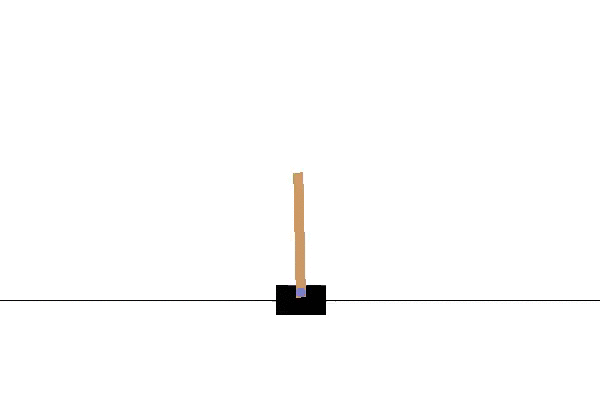
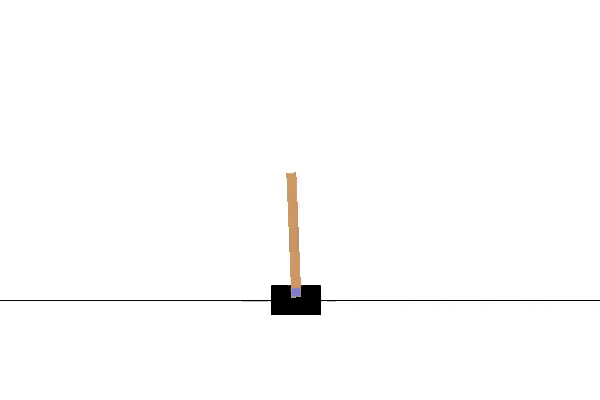
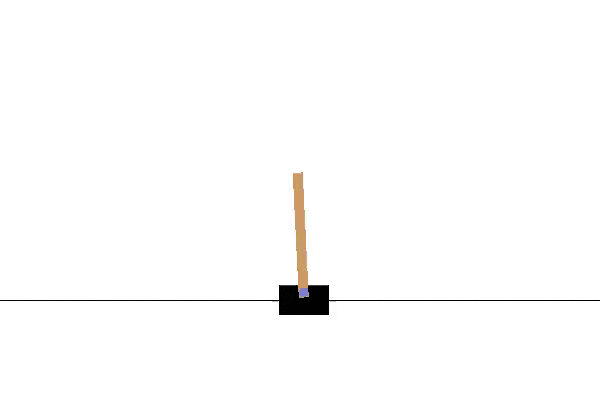

In [18]:
best_agent.demo()

In [19]:
vpg_max_t, vpg_max_sec, vpg_max_r, vpg_max_s = np.max(vpg_results, axis=0).T
vpg_min_t, vpg_min_sec, vpg_min_r, vpg_min_s = np.min(vpg_results, axis=0).T
vpg_mean_t, vpg_mean_sec, vpg_mean_r, vpg_mean_s = np.mean(vpg_results, axis=0).T
vpg_x = np.arange(np.max((len(vpg_mean_s), len(reinforce_mean_s))))

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


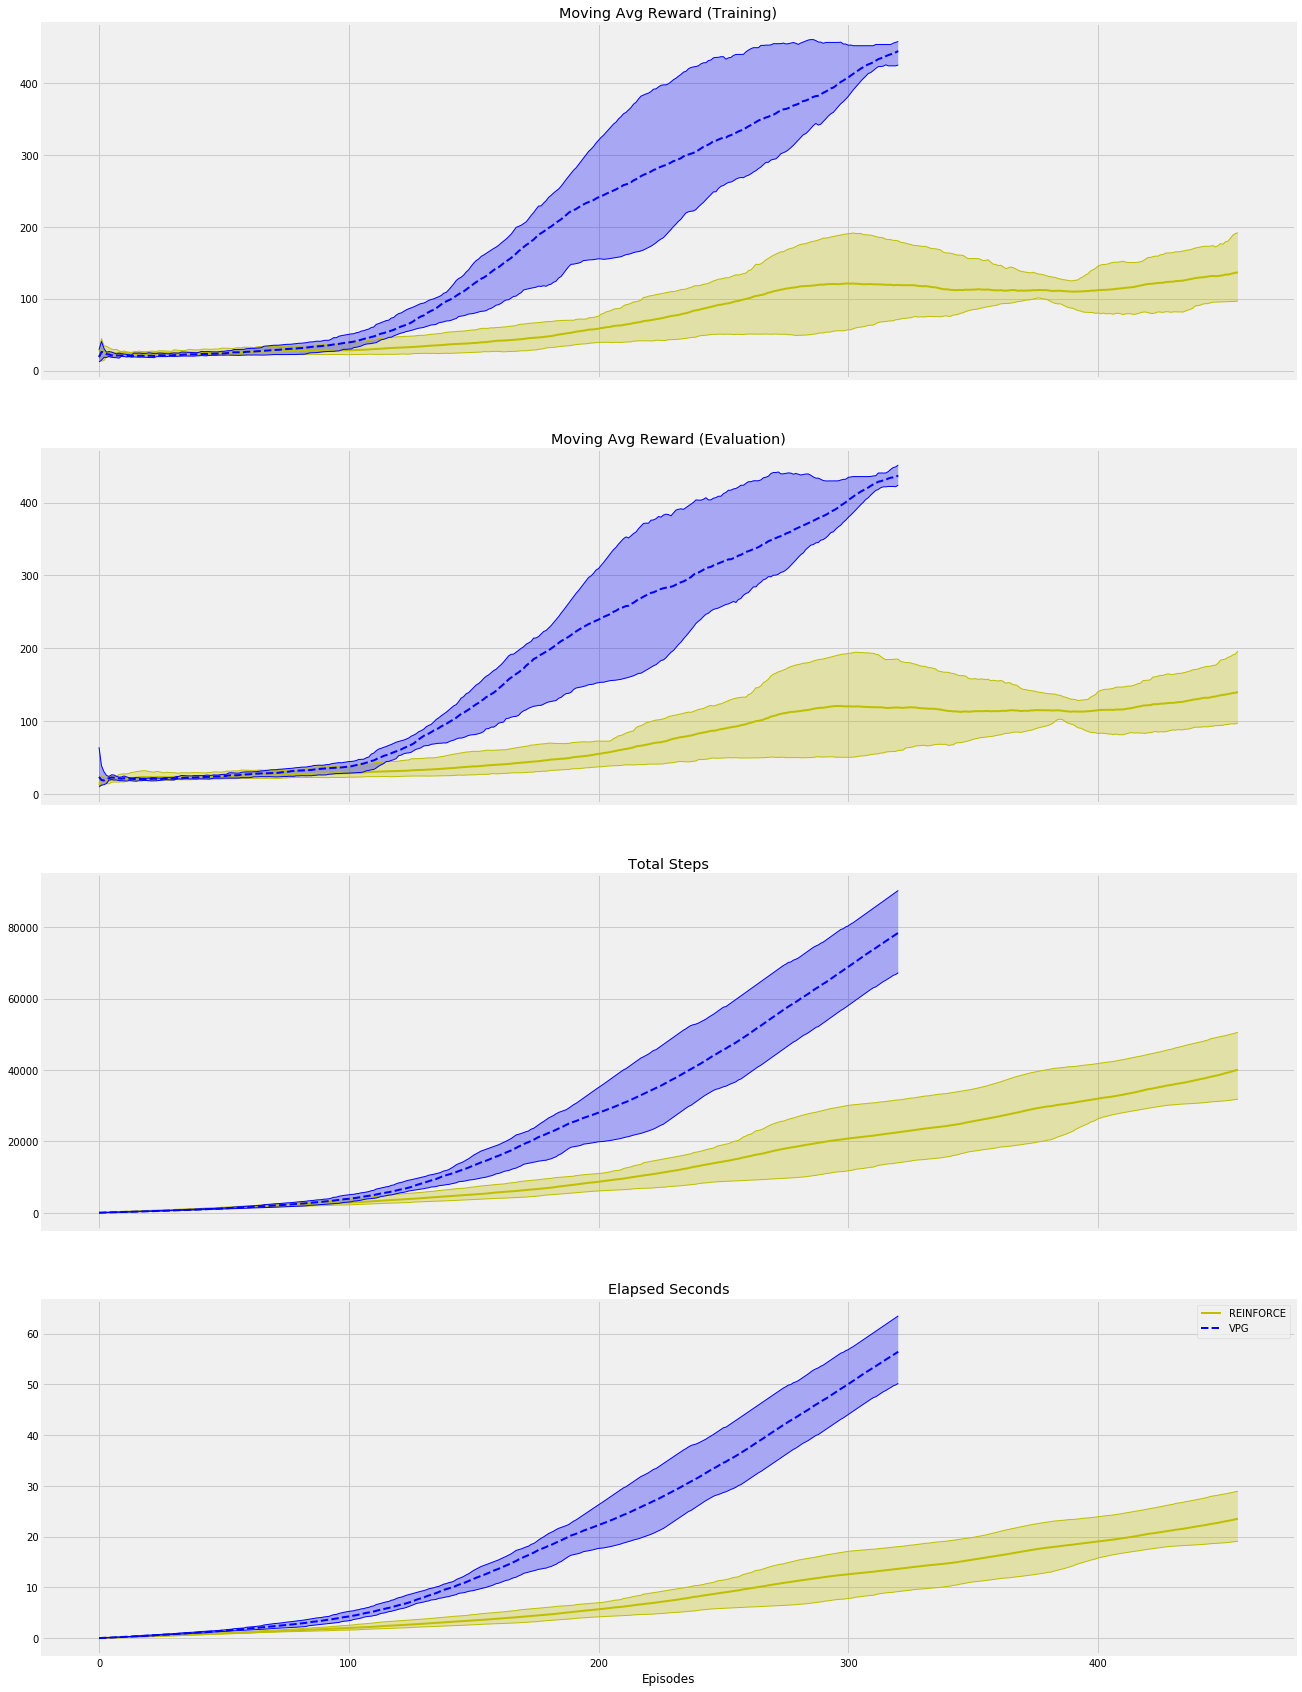

In [20]:
fig, axs = plt.subplots(4, 1, figsize=(20,30), sharey=False, sharex=True)

# REINFORCE
axs[0].plot(reinforce_max_r, 'y', linewidth=1)
axs[0].plot(reinforce_min_r, 'y', linewidth=1)
axs[0].plot(reinforce_mean_r, 'y', label='REINFORCE', linewidth=2)
axs[0].fill_between(reinforce_x, reinforce_min_r, reinforce_max_r, facecolor='y', alpha=0.3)

axs[1].plot(reinforce_max_s, 'y', linewidth=1)
axs[1].plot(reinforce_min_s, 'y', linewidth=1)
axs[1].plot(reinforce_mean_s, 'y', label='REINFORCE', linewidth=2)
axs[1].fill_between(reinforce_x, reinforce_min_s, reinforce_max_s, facecolor='y', alpha=0.3)

axs[2].plot(reinforce_max_t, 'y', linewidth=1)
axs[2].plot(reinforce_min_t, 'y', linewidth=1)
axs[2].plot(reinforce_mean_t, 'y', label='REINFORCE', linewidth=2)
axs[2].fill_between(reinforce_x, reinforce_min_t, reinforce_max_t, facecolor='y', alpha=0.3)

axs[3].plot(reinforce_max_sec, 'y', linewidth=1)
axs[3].plot(reinforce_min_sec, 'y', linewidth=1)
axs[3].plot(reinforce_mean_sec, 'y', label='REINFORCE', linewidth=2)
axs[3].fill_between(reinforce_x, reinforce_min_sec, reinforce_max_sec, facecolor='y', alpha=0.3)

# VPG
axs[0].plot(vpg_max_r, 'b', linewidth=1)
axs[0].plot(vpg_min_r, 'b', linewidth=1)
axs[0].plot(vpg_mean_r, 'b--', label='VPG', linewidth=2)
axs[0].fill_between(vpg_x, vpg_min_r, vpg_max_r, facecolor='b', alpha=0.3)

axs[1].plot(vpg_max_s, 'b', linewidth=1)
axs[1].plot(vpg_min_s, 'b', linewidth=1)
axs[1].plot(vpg_mean_s, 'b--', label='VPG', linewidth=2)
axs[1].fill_between(vpg_x, vpg_min_s, vpg_max_s, facecolor='b', alpha=0.3)

axs[2].plot(vpg_max_t, 'b', linewidth=1)
axs[2].plot(vpg_min_t, 'b', linewidth=1)
axs[2].plot(vpg_mean_t, 'b--', label='VPG', linewidth=2)
axs[2].fill_between(vpg_x, vpg_min_t, vpg_max_t, facecolor='b', alpha=0.3)

axs[3].plot(vpg_max_sec, 'b', linewidth=1)
axs[3].plot(vpg_min_sec, 'b', linewidth=1)
axs[3].plot(vpg_mean_sec, 'b--', label='VPG', linewidth=2)
axs[3].fill_between(vpg_x, vpg_min_sec, vpg_max_sec, facecolor='b', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Elapsed Seconds')
plt.xlabel('Episodes')
plt.legend()
plt.show()

# A3C

In [22]:
class SharedAdam(torch.optim.Adam):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        super(SharedAdam, self).__init__(params, lr, betas, eps, weight_decay)
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = 0
                state['shared_steps'] = torch.zeros(1).share_memory_()
                state['exp_avg'] = p.data.new().resize_as_(p.data).zero_().share_memory_()
                state['exp_avg_sq'] = p.data.new().resize_as_(p.data).zero_().share_memory_()

        def step(self, closure=None):
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is None: continue
                    self.state[p]['shared_steps'] += 1
                    self.state[p]['step'] = self.state[p]['shared_steps'][0] - 1
            super.step(closure)

In [23]:
class SharedRMSprop(torch.optim.RMSprop):
    def __init__(self, params, lr=1e-2, alpha=0.99, eps=1e-8, weight_decay=0):
        super(SharedRMSprop, self).__init__(params, lr=lr, alpha=alpha, eps=eps, weight_decay=weight_decay, momentum=0, centered=False)
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = 0
                state['shared_steps'] = torch.zeros(1).share_memory_()
                state['square_avg'] = p.data.new().resize_as_(p.data).zero_().share_memory_()

        def step(self, closure=None):
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is None: continue
                    self.state[p]['shared_steps'] += 1
                    self.state[p]['step'] = self.state[p]['shared_steps'][0] - 1
            super.step(closure)

In [42]:
class A3C():
    def __init__(self, policy_model_fn, policy_model_max_grad_norm, policy_optimizer_fn, policy_optimizer_lr,
                 value_model_fn, value_model_max_grad_norm, value_optimizer_fn, value_optimizer_lr, 
                 entropy_loss_weight, n_steps_max, n_workers):
        self.policy_model_fn = policy_model_fn
        self.policy_model_max_grad_norm = policy_model_max_grad_norm
        self.policy_optimizer_fn = policy_optimizer_fn
        self.policy_optimizer_lr = policy_optimizer_lr
        
        self.value_model_fn = value_model_fn
        self.value_model_max_grad_norm = value_model_max_grad_norm
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr
        
        self.entropy_loss_weight = entropy_loss_weight
        self.n_steps_max = n_steps_max
        self.n_workers = n_workers

    def optimize_model(self, next_value, 
                       logpas, entropies, rewards, values, 
                       local_policy_model, local_value_model):
        T = len(rewards)
        discounts = np.logspace(0, T+1, num=T+1, base=self.gamma, endpoint=False)
        rewards = np.array(rewards)
        returns = np.array([np.sum(discounts[:T-t] * (rewards[t:] + [next_value,])) for t in range(T)])

        discounts = torch.FloatTensor(discounts[:-1]).unsqueeze(1)
        returns = torch.FloatTensor(returns).unsqueeze(1)
        logpas = torch.cat(logpas)
        entropies = torch.cat(entropies)
        values = torch.cat(values)
        
        value_error = returns - values
        value_loss = value_error.pow(2).mul(0.5).mean()

        self.shared_value_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(local_value_model.parameters(), 
                                       self.value_model_max_grad_norm)
        for param, shared_param in zip(local_value_model.parameters(), 
                                       self.shared_value_model.parameters()):
            if shared_param.grad is None:
                shared_param._grad = param.grad
        self.shared_value_optimizer.step()

        policy_loss = -(discounts * value_error.detach() * logpas).mean()
        entropy_loss = -(self.entropy_loss_weight * entropies).mean()
        policy_loss = policy_loss + entropy_loss
        self.shared_policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(local_policy_model.parameters(), 
                                       self.policy_model_max_grad_norm)
        for param, shared_param in zip(local_policy_model.parameters(), 
                                       self.shared_policy_model.parameters()):
            if shared_param.grad is None:
                shared_param._grad = param.grad
        self.shared_policy_optimizer.step()
        
    def interaction_step(self, state, env, local_policy_model, local_value_model, 
                         logpas, entropies, rewards, values):
        action, logpa, entropy = local_policy_model.select_action(state)
        new_state, reward, is_terminal, _ = env.step(action)
        value = local_value_model(state)

        logpas.append(logpa)
        entropies.append(entropy)
        rewards.append(reward)
        values.append(value)
        
        return new_state, reward, is_terminal

    def work(self, rank):
        training_start, last_debug_time = time.time(), float('-inf')

        local_seed = self.seed + rank
        env = self.make_env_fn(**self.make_env_kargs, seed=local_seed)
        torch.manual_seed(local_seed)
        np.random.seed(local_seed)
        random.seed(local_seed)

        with self.active_workers_counter_lock:
            self.active_workers_counter.add_(1)
        
        with self.episode_global_counter_lock:
            episode_global_counter = self.episode_global_counter.item()
            self.episode_global_counter.add_(1)

        nS, nA = env.observation_space.shape[0], env.action_space.n
        local_policy_model = self.policy_model_fn(nS, nA)
        local_policy_optimizer = self.policy_optimizer_fn(local_policy_model, 
                                                          self.policy_optimizer_lr)
        local_value_model = self.value_model_fn(nS)
        local_value_optimizer = self.value_optimizer_fn(local_value_model, 
                                                        self.value_optimizer_lr)

        for _ in range(max_episodes):
            episode_start = time.time()

            state, is_terminal = env.reset(), False
            local_policy_model.load_state_dict(self.shared_policy_model.state_dict())
            local_value_model.load_state_dict(self.shared_value_model.state_dict())

            # collect n_steps rollout
            n_steps_start = 0
            logpas, entropies, rewards, values = [], [], [], []
            for step in count(start=1):
                with self.timestep_global_counter_lock:
                    timestep_global_counter = self.timestep_global_counter.item()
                    self.timestep_global_counter.add_(1)

                state, reward, is_terminal = self.interaction_step(
                    state, env, local_policy_model, local_value_model, logpas, entropies, rewards, values)

                self.episode_reward[episode_global_counter].add_(reward)
                if is_terminal or step - n_steps_start == self.n_steps_max:
                    past_limit_enforced = hasattr(env, '_past_limit') and env._past_limit()
                    failure = is_terminal and not past_limit_enforced
                    next_value = 0 if failure else local_value_model(state).detach().item()
                    self.optimize_model(next_value, 
                                        logpas, entropies, rewards, values, 
                                        local_policy_model, local_value_model)
                    logpas, entropies, rewards, values = [], [], [], []
                    n_steps_start = step
                if is_terminal:
                    break


            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds[episode_global_counter].add_(episode_elapsed)
            self.training_time.add_(episode_elapsed)
            evaluation_score, _ = self.evaluate(self.shared_policy_model, env)
            self.evaluation_scores[episode_global_counter].add_(evaluation_score)

            sec_per_ep = self.episode_seconds[:episode_global_counter+1].mean().item()
            mean_10_reward = self.episode_reward[:episode_global_counter+1][-10:].mean().item()
            std_10_reward = self.episode_reward[:episode_global_counter+1][-10:].std().item()
            mean_100_reward = self.episode_reward[:episode_global_counter+1][-100:].mean().item()
            std_100_reward = self.episode_reward[:episode_global_counter+1][-100:].std().item()
            mean_100_eval_score = self.evaluation_scores[:episode_global_counter+1][-100:].mean().item()
            std_100_eval_score = self.evaluation_scores[:episode_global_counter+1][-100:].std().item()
            
            self.result[episode_global_counter][0].add_(timestep_global_counter)
            self.result[episode_global_counter][1].add_(episode_elapsed)
            self.result[episode_global_counter][2].add_(mean_100_reward)
            self.result[episode_global_counter][3].add_(mean_100_eval_score)
            
            with self.episode_global_counter_lock:
                old_episode_global_counter = episode_global_counter
                episode_global_counter = self.episode_global_counter.item()
                reached_debug_time = time.time() - last_debug_time >= 10
                reached_max_minutes = time.time() - training_start >= self.max_minutes * 60
                reached_max_episodes = episode_global_counter >= self.max_episodes
                reached_training_goal = mean_100_reward >= self.goal_mean_100_reward
                reached_eval_goal = mean_100_eval_score >= self.goal_mean_100_reward
                reached_goal_mean_reward =  reached_training_goal and reached_eval_goal 
                training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
                last_active_worker = False
                if training_is_over:
                    with self.active_workers_counter_lock:
                        last_active_worker = self.active_workers_counter.item() == 1
                        self.active_workers_counter.sub_(1)
                else:
                    self.episode_global_counter.add_(1)

            if (rank == 0 and reached_debug_time) or (last_active_worker and training_is_over):
                elapsed_str = time.strftime("%M:%S", time.gmtime(time.time() - training_start))
                debug_message = 'elp {}, ep {:04}, stps {:06}, s/ep {:.3f}, '
                debug_message += u'av r - lst10 {:06.2f}\u00B1{:06.2f} - lst100 {:06.2f}\u00B1{:06.2f}, '
                debug_message += 'eval {:06.2f}\u00B1{:06.2f}'
                debug_message = debug_message.format(
                    elapsed_str, old_episode_global_counter, timestep_global_counter, sec_per_ep, 
                    mean_10_reward, std_10_reward, mean_100_reward, std_100_reward, 
                    mean_100_eval_score, std_100_eval_score)
                print(debug_message)
                last_debug_time = time.time()                
            if last_active_worker and training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
            if training_is_over:
                break

        if last_active_worker:
            final_eval_score, score_std = self.evaluate(self.shared_policy_model, env, n_episodes=100)
            print('Training complete.')
            print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time.\n'.format(
                final_eval_score, score_std, training_time))
            self.final_eval_score.add_(final_eval_score)
            self.episode_global_counter.sub_(1)

        env.close()
        del env

    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):

        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        self.max_minutes = max_minutes
        self.max_episodes = max_episodes
        self.goal_mean_100_reward = goal_mean_100_reward

        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        nS, nA = env.observation_space.shape[0], env.action_space.n
        env.close()
        del env

        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)

        self.active_workers_counter_lock = mp.Lock()
        self.episode_global_counter_lock = mp.Lock()
        self.timestep_global_counter_lock = mp.Lock()

        self.result = torch.zeros([max_episodes, 4]).share_memory_()
        self.evaluation_scores = torch.zeros([max_episodes]).share_memory_()
        self.episode_seconds = torch.zeros([max_episodes]).share_memory_()
        self.episode_reward = torch.zeros([max_episodes]).share_memory_()
        self.episode_timestep = torch.zeros([max_episodes], dtype=torch.int).share_memory_()
        self.episode_global_counter = torch.zeros(1, dtype=torch.int).share_memory_()
        self.timestep_global_counter = torch.zeros(1, dtype=torch.int).share_memory_()
        self.active_workers_counter = torch.zeros(1, dtype=torch.int).share_memory_()
        self.training_time = torch.zeros(1, dtype=torch.int).share_memory_()
        self.final_eval_score = torch.zeros(1, dtype=torch.float).share_memory_()

        self.shared_policy_model = self.policy_model_fn(nS, nA).share_memory()
        self.shared_policy_optimizer = self.policy_optimizer_fn(
            self.shared_policy_model, self.policy_optimizer_lr)

        self.shared_value_model = self.value_model_fn(nS).share_memory()
        self.shared_value_optimizer = self.value_optimizer_fn(
            self.shared_value_model, self.value_optimizer_lr)
        
        workers = []
        for rank in range(self.n_workers):
            w = mp.Process(target=self.work, args=(rank,))
            workers.append(w)

        [w.start() for w in workers]
        [w.join() for w in workers]

        self.result = self.result.numpy()
        self.result[self.episode_global_counter.item()+1:, ...] = np.nan
        return self.result, self.final_eval_score.item(), self.training_time.item()

    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                a, _, _ = eval_policy_model.select_action(s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)
    
    def demo(self, title='Trained A3C Agent', n_episodes=10, max_n_videos=3):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation')
        self.evaluate(self.policy_model, env, n_episodes=n_episodes)
        env.close()
        data = get_gif_html(env_videos=env.videos, title=title, max_n_videos=max_n_videos)
        return HTML(data=data)

In [61]:
a3c_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in [12,]:# 34, 56, 78, 90]:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 1.0,
        'max_minutes': 5,
        'max_episodes': 5000,
        'goal_mean_100_reward': 450
    }

    policy_model_fn = lambda nS, nA: FCDP(nS, nA, hidden_dims=(256,256))
    policy_model_max_grad_norm = 25
    policy_optimizer_fn = lambda net, lr: SharedAdam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.0005
    entropy_loss_weight = 0.0001

    value_model_fn = lambda nS: FCV(nS, hidden_dims=(256,256))
    value_model_max_grad_norm = 10
    value_optimizer_fn = lambda net, lr: SharedRMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.001

    n_steps_max = 1000
    n_workers = 8

    env_name, gamma, max_minutes, max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = A3C(policy_model_fn, policy_model_max_grad_norm, policy_optimizer_fn, policy_optimizer_lr,
                value_model_fn, value_model_max_grad_norm, value_optimizer_fn, value_optimizer_lr,
                entropy_loss_weight, n_steps_max, n_workers)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time = agent.train(make_env_fn, make_env_kargs, seed, gamma,
                                                          max_minutes, max_episodes, goal_mean_100_reward)
    a3c_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
a3c_results = np.array(a3c_results)

elp 00:00, ep 0000, stps 000019, s/ep 0.033, av r - lst10 017.00±000nan - lst100 017.00±000nan, eval 013.00±000nan
elp 00:10, ep 0438, stps 072210, s/ep 0.137, av r - lst10 386.60±126.13 - lst100 334.60±115.94, eval 317.02±119.39
elp 00:20, ep 0621, stps 151684, s/ep 0.195, av r - lst10 460.80±080.84 - lst100 427.40±098.78, eval 421.73±098.99
elp 00:23, ep 0666, stps 172574, s/ep 0.206, av r - lst10 487.70±038.90 - lst100 463.61±081.76, eval 464.26±085.22
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score 495.10±40.56 in 0.00s training time.



In [25]:
best_agent.demo()

KeyboardInterrupt: 

In [44]:
a3c_max_t, a3c_max_sec, a3c_max_r, a3c_max_s = np.max(a3c_results, axis=0).T
a3c_min_t, a3c_min_sec, a3c_min_r, a3c_min_s = np.min(a3c_results, axis=0).T
a3c_mean_t, a3c_mean_sec, a3c_mean_r, a3c_mean_s = np.mean(a3c_results, axis=0).T
a3c_x = np.arange(np.max((len(a3c_mean_s), len(vpg_mean_s), len(reinforce_mean_s))))

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


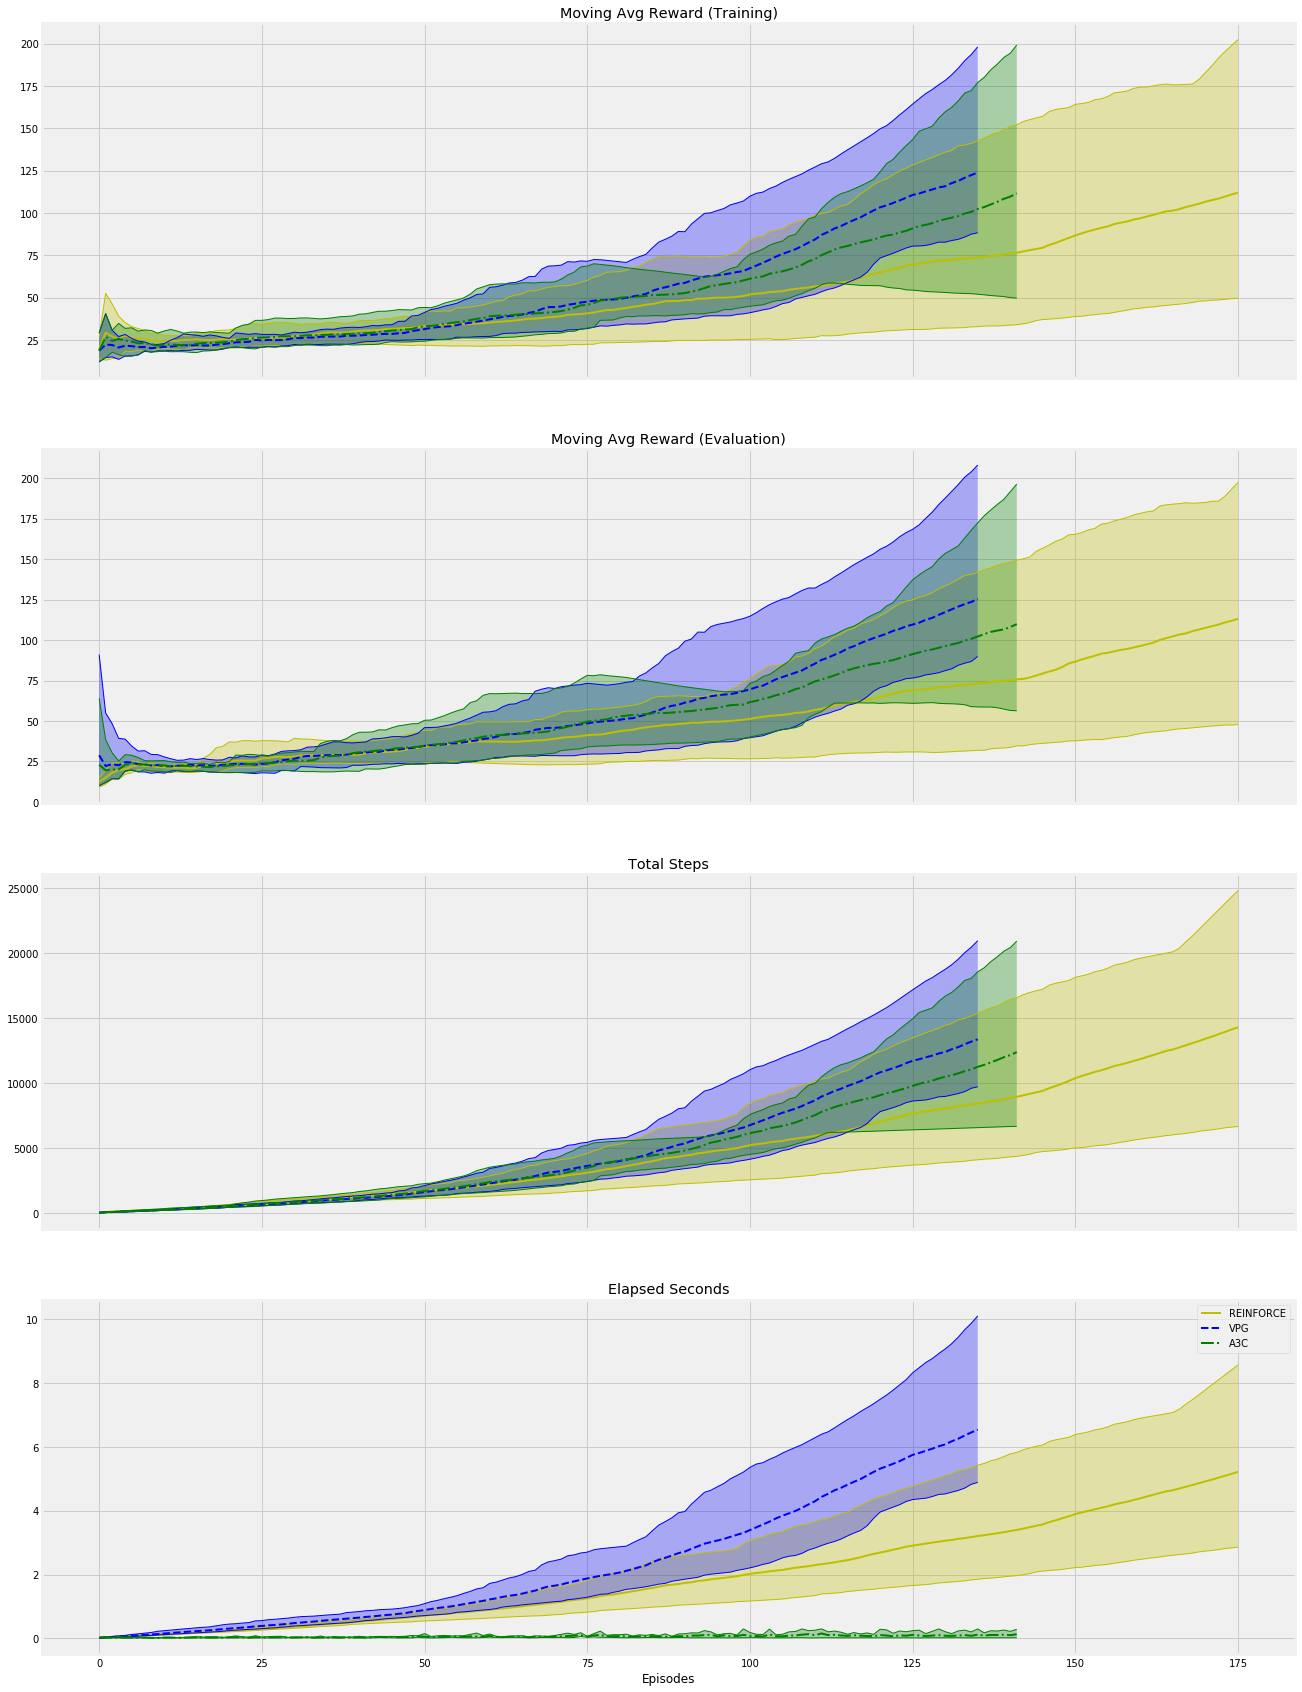

In [45]:
fig, axs = plt.subplots(4, 1, figsize=(20,30), sharey=False, sharex=True)

# REINFORCE
axs[0].plot(reinforce_max_r, 'y', linewidth=1)
axs[0].plot(reinforce_min_r, 'y', linewidth=1)
axs[0].plot(reinforce_mean_r, 'y', label='REINFORCE', linewidth=2)
axs[0].fill_between(reinforce_x, reinforce_min_r, reinforce_max_r, facecolor='y', alpha=0.3)

axs[1].plot(reinforce_max_s, 'y', linewidth=1)
axs[1].plot(reinforce_min_s, 'y', linewidth=1)
axs[1].plot(reinforce_mean_s, 'y', label='REINFORCE', linewidth=2)
axs[1].fill_between(reinforce_x, reinforce_min_s, reinforce_max_s, facecolor='y', alpha=0.3)

axs[2].plot(reinforce_max_t, 'y', linewidth=1)
axs[2].plot(reinforce_min_t, 'y', linewidth=1)
axs[2].plot(reinforce_mean_t, 'y', label='REINFORCE', linewidth=2)
axs[2].fill_between(reinforce_x, reinforce_min_t, reinforce_max_t, facecolor='y', alpha=0.3)

axs[3].plot(reinforce_max_sec, 'y', linewidth=1)
axs[3].plot(reinforce_min_sec, 'y', linewidth=1)
axs[3].plot(reinforce_mean_sec, 'y', label='REINFORCE', linewidth=2)
axs[3].fill_between(reinforce_x, reinforce_min_sec, reinforce_max_sec, facecolor='y', alpha=0.3)

# VPG
axs[0].plot(vpg_max_r, 'b', linewidth=1)
axs[0].plot(vpg_min_r, 'b', linewidth=1)
axs[0].plot(vpg_mean_r, 'b--', label='VPG', linewidth=2)
axs[0].fill_between(vpg_x, vpg_min_r, vpg_max_r, facecolor='b', alpha=0.3)

axs[1].plot(vpg_max_s, 'b', linewidth=1)
axs[1].plot(vpg_min_s, 'b', linewidth=1)
axs[1].plot(vpg_mean_s, 'b--', label='VPG', linewidth=2)
axs[1].fill_between(vpg_x, vpg_min_s, vpg_max_s, facecolor='b', alpha=0.3)

axs[2].plot(vpg_max_t, 'b', linewidth=1)
axs[2].plot(vpg_min_t, 'b', linewidth=1)
axs[2].plot(vpg_mean_t, 'b--', label='VPG', linewidth=2)
axs[2].fill_between(vpg_x, vpg_min_t, vpg_max_t, facecolor='b', alpha=0.3)

axs[3].plot(vpg_max_sec, 'b', linewidth=1)
axs[3].plot(vpg_min_sec, 'b', linewidth=1)
axs[3].plot(vpg_mean_sec, 'b--', label='VPG', linewidth=2)
axs[3].fill_between(vpg_x, vpg_min_sec, vpg_max_sec, facecolor='b', alpha=0.3)

# A3C
axs[0].plot(a3c_max_r, 'g', linewidth=1)
axs[0].plot(a3c_min_r, 'g', linewidth=1)
axs[0].plot(a3c_mean_r, 'g-.', label='A3C', linewidth=2)
axs[0].fill_between(a3c_x, a3c_min_r, a3c_max_r, facecolor='g', alpha=0.3)

axs[1].plot(a3c_max_s, 'g', linewidth=1)
axs[1].plot(a3c_min_s, 'g', linewidth=1)
axs[1].plot(a3c_mean_s, 'g-.', label='A3C', linewidth=2)
axs[1].fill_between(a3c_x, a3c_min_s, a3c_max_s, facecolor='g', alpha=0.3)

axs[2].plot(a3c_max_t, 'g', linewidth=1)
axs[2].plot(a3c_min_t, 'g', linewidth=1)
axs[2].plot(a3c_mean_t, 'g-.', label='A3C', linewidth=2)
axs[2].fill_between(a3c_x, a3c_min_t, a3c_max_t, facecolor='g', alpha=0.3)

axs[3].plot(a3c_max_sec, 'g', linewidth=1)
axs[3].plot(a3c_min_sec, 'g', linewidth=1)
axs[3].plot(a3c_mean_sec, 'g-.', label='A3C', linewidth=2)
axs[3].fill_between(a3c_x, a3c_min_sec, a3c_max_sec, facecolor='g', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Elapsed Seconds')
plt.xlabel('Episodes')
plt.legend()
plt.show()

# GAE

In [158]:
class GAE():
    def __init__(self, policy_model_fn, policy_optimizer_fn, policy_optimizer_lr, policy_model_max_grad_mag,
                 value_model_fn, value_optimizer_fn, value_optimizer_lr, value_model_max_grad_mag,
                 entropy_loss_weight, t_max, n_workers, tau):

        self.policy_model_fn = policy_model_fn
        self.policy_optimizer_fn = policy_optimizer_fn
        self.policy_optimizer_lr = policy_optimizer_lr
        self.policy_model_max_grad_mag = policy_model_max_grad_mag
        
        self.value_model_fn = value_model_fn
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr
        self.value_model_max_grad_mag = value_model_max_grad_mag
        
        self.entropy_loss_weight = entropy_loss_weight
        self.t_max = t_max
        self.n_workers = n_workers
        self.tau = tau

    def optimize_model(self, next_value, rewards, logps, actions, values, 
                       local_policy_model, local_value_model):
        num_steps = len(rewards) + 1
        discounts = np.logspace(0, num_steps, num=num_steps, base=self.gamma, endpoint=False)
        returns = []
        for step_idx in range(num_steps - 1):
            last_idx = num_steps-step_idx
            returns.append(np.sum(discounts[:last_idx] * (rewards[step_idx:] + [next_value,])))

        logps = torch.cat(logps)
        actions = torch.LongTensor(actions)
        returns = torch.FloatTensor(returns).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        values = torch.cat(values)
        
        num_steps = len(rewards)
        tau_discounts = np.logspace(0, num_steps, num=num_steps, base=self.gamma, endpoint=False) * self.tau
        deltas = rewards + self.gamma * torch.cat((values[1:], torch.Tensor([[next_value,],]))) - values
        gae = []
        for step_idx in range(num_steps):
            last_idx = num_steps-step_idx
            gae.append((torch.Tensor(tau_discounts[:last_idx]).unsqueeze(1) * deltas[step_idx:]).sum())

        gae = torch.FloatTensor(gae).unsqueeze(1)

        value_error = returns.detach() - values
        value_loss = value_error.pow(2).mul(0.5).mean()
        
        policy_loss = -(logps[np.arange(num_steps), actions] * gae.detach()).sum()
        entropy_loss = (logps * torch.exp(logps)).sum()
        policy_loss = policy_loss + self.entropy_loss_weight * entropy_loss

        # with self.models_lock:
        self.shared_value_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(local_value_model.parameters(), 
                                       self.value_model_max_grad_mag)
        for param, shared_param in zip(local_value_model.parameters(), 
                                       self.shared_value_model.parameters()):
            if shared_param.grad is None:
                shared_param._grad = param.grad
        self.shared_value_optimizer.step()

        self.shared_policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(local_policy_model.parameters(), 
                                       self.policy_model_max_grad_mag)
        for param, shared_param in zip(local_policy_model.parameters(), 
                                       self.shared_policy_model.parameters()):
            if shared_param.grad is None:
                shared_param._grad = param.grad
        self.shared_policy_optimizer.step()

    def work(self, rank, max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')
        local_seed = self.base_seed + rank
        env = self.make_env_fn(self.env_name, seed=local_seed)
        torch.manual_seed(local_seed)
        np.random.seed(local_seed)
        random.seed(local_seed)
        
        with self.active_workers_counter_lock:
            self.active_workers_counter.add_(1)
        
        with self.episode_global_counter_lock:
            episode_global_counter = self.episode_global_counter.item()
            self.episode_global_counter.add_(1)
            
        nS, nA = env.observation_space.shape[0], env.action_space.n
        local_policy_model = self.policy_model_fn(nS, nA)
        local_policy_optimizer = self.policy_optimizer_fn(
            local_policy_model, self.policy_optimizer_lr)
        
        local_value_model = self.value_model_fn(nS)
        local_value_optimizer = self.value_optimizer_fn(
            local_value_model, self.value_optimizer_lr)

        for _ in range(max_episodes):
            episode_start = time.time()
            #with self.models_lock:
            local_policy_model.load_state_dict(self.shared_policy_model.state_dict())
            local_value_model.load_state_dict(self.shared_value_model.state_dict())

            state, is_terminal = env.reset(), False

            # collect rollout
            t_start = 0
            logps, actions, rewards, values = [], [], [], []
            for timestep in count(start=1):
                with self.timestep_global_counter_lock:
                    timestep_global_counter = self.timestep_global_counter.item()
                    self.timestep_global_counter.add_(1)
                
                action, logp = local_policy_model.select_action(state)
                state, reward, is_terminal, _ = env.step(action)
                value = local_value_model(state)
                logps.append(logp) ; actions.append(action) ; rewards.append(reward) ; values.append(value)
                
                self.episode_reward[episode_global_counter].add_(reward)
                if is_terminal or timestep - t_start == self.t_max:
                    next_value = 0 if is_terminal and not env._past_limit() \
                        else local_value_model(state).detach().item()
                    self.optimize_model(next_value, rewards, logps, actions, values, 
                                        local_policy_model, local_value_model)                    
                    logps, actions, rewards, values = [], [], [], []
                    t_start = timestep
                if is_terminal:
                    break

            # stats
            self.episode_seconds[episode_global_counter].add_(time.time() - episode_start)
            evaluation_score = self.evaluate(local_policy_model, env)
            self.evaluation_scores[episode_global_counter].add_(evaluation_score)
            elapsed = time.time() - training_start
            
            sec_per_ep = self.episode_seconds[:episode_global_counter+1].mean().item()
            mean_25_reward = self.episode_reward[:episode_global_counter+1][-25:].mean().item()
            mean_50_reward = self.episode_reward[:episode_global_counter+1][-50:].mean().item()
            mean_100_reward = self.episode_reward[:episode_global_counter+1][-100:].mean().item()
            mean_100_eval_score = self.evaluation_scores[:episode_global_counter+1][-100:].mean().item()
            
            self.result[episode_global_counter][0].add_(timestep_global_counter)
            self.result[episode_global_counter][1].add_(elapsed)
            self.result[episode_global_counter][2].add_(mean_100_reward)
            self.result[episode_global_counter][3].add_(mean_100_eval_score)
            
            with self.episode_global_counter_lock:
                old_episode_global_counter = episode_global_counter
                episode_global_counter = self.episode_global_counter.item()
                reached_debug_time = time.time() - last_debug_time >= 10
                reached_max_minutes = time.time() - training_start >= max_minutes * 60
                reached_max_episodes = episode_global_counter >= max_episodes
                reached_training_goal = mean_100_reward >= goal_mean_100_reward
                reached_eval_goal = mean_100_eval_score >= goal_mean_100_reward
                reached_goal_mean_reward =  reached_training_goal and reached_eval_goal 
                training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
                last_active_worker = False
                if training_is_over:
                    with self.active_workers_counter_lock:
                        last_active_worker = self.active_workers_counter.item() == 1
                        self.active_workers_counter.sub_(1)
                else:
                    self.episode_global_counter.add_(1)

            if (rank == 0 and reached_debug_time) or (last_active_worker and training_is_over):
                elapsed_str = time.strftime("%Mm %Ss", time.gmtime(elapsed))
                debug_message = 'elp {}, ep {:04}, stps {:06}, s/ep {:.3f}, '
                debug_message += 'r/ep - lst 25 = {:06.2f}, 50 = {:06.2f}, 100 = {:06.2f}, '
                debug_message += 'lst 100 evl {:06.2f}'
                debug_message = debug_message.format(
                    elapsed_str, old_episode_global_counter, timestep_global_counter, sec_per_ep,
                    mean_25_reward, mean_50_reward, mean_100_reward, mean_100_eval_score)
                print(debug_message)
                last_debug_time = time.time()                
            if last_active_worker and training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
            if training_is_over:
                break

        if last_active_worker:
            # with self.models_lock:
            final_eval_score = self.evaluate(self.shared_policy_model, env, n_episodes=10)
            print('Training complete. Final evaluation score {:.2f}.\n'.format(final_eval_score))
            self.final_eval_score.add_(final_eval_score)
            self.episode_global_counter.sub_(1)

        env.close()
        del env

    def train(self, env_name, make_env_fn, base_seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        self.env_name = env_name
        self.make_env_fn = make_env_fn
        self.base_seed = base_seed
        self.gamma = gamma
    
        env = self.make_env_fn(self.env_name, seed=self.base_seed)
        nS, nA = env.observation_space.shape[0], env.action_space.n
        env.close()
        del env
        torch.manual_seed(self.base_seed)
        np.random.seed(self.base_seed)
        random.seed(self.base_seed)
    
        # self.models_lock = mp.Lock()
        self.active_workers_counter_lock = mp.Lock()
        self.episode_global_counter_lock = mp.Lock()
        self.timestep_global_counter_lock = mp.Lock()

        self.result = torch.zeros([max_episodes, 4]).share_memory_()
        self.evaluation_scores = torch.zeros([max_episodes]).share_memory_()
        self.episode_seconds = torch.zeros([max_episodes]).share_memory_()
        self.episode_reward = torch.zeros([max_episodes]).share_memory_()
        self.episode_timestep = torch.zeros([max_episodes], dtype=torch.int).share_memory_()
        self.episode_global_counter = torch.zeros(1, dtype=torch.int).share_memory_()
        self.timestep_global_counter = torch.zeros(1, dtype=torch.int).share_memory_()
        self.active_workers_counter = torch.zeros(1, dtype=torch.int).share_memory_()
        self.final_eval_score = torch.zeros(1, dtype=torch.float).share_memory_()

        #with self.models_lock:
        self.shared_policy_model = self.policy_model_fn(nS, nA).share_memory()
        self.shared_policy_optimizer = self.policy_optimizer_fn(
            self.shared_policy_model, self.policy_optimizer_lr)

        self.shared_value_model = self.value_model_fn(nS).share_memory()
        self.shared_value_optimizer = self.value_optimizer_fn(
            self.shared_value_model, self.value_optimizer_lr)
        
        workers = []
        for rank in range(self.n_workers):
            w = mp.Process(target=self.work,
                           args=(rank, max_minutes, max_episodes, goal_mean_100_reward))
            workers.append(w)

        [w.start() for w in workers]
        [w.join() for w in workers]
        self.result = self.result.numpy()
        self.result[self.episode_global_counter.item()+1:, ...] = np.nan
        return self.result, self.final_eval_score.item()

    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                a, _ = eval_policy_model.select_action(s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs)
    
    def demo(self, title='Trained A3C Agent', n_episodes=10, max_n_videos=3):
        env = self.make_env_fn(self.env_name, monitor_mode='evaluation')
        # with self.models_lock:
        self.evaluate(self.shared_policy_model, env, n_episodes=10)
        env.close()
        data = get_gif_html(env_videos=env.videos, title=title, max_n_videos=max_n_videos)
        return HTML(data=data)

In [159]:
gae_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in [12, 34, 56, 78, 90]:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 1.00,
        'max_minutes': 2.5,
        'max_episodes': 10000,
        'goal_mean_100_reward': 195
    }

    policy_model_fn = lambda nS, nA: FCDPC(nS, nA, hidden_dims=(256,256))
    policy_optimizer_fn = lambda net, lr: SharedAdam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.0003
    policy_model_max_grad_mag = 10

    value_model_fn = lambda nS: FCVC(nS, hidden_dims=(256,256))
    value_optimizer_fn = lambda net, lr: SharedRMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.005
    value_model_max_grad_mag = float('inf')

    entropy_loss_weight = 0.01
    t_max = 20
    n_workers = 8
    tau = 0.85

    env_name, gamma, max_minutes, max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = GAE(policy_model_fn, policy_optimizer_fn, policy_optimizer_lr, policy_model_max_grad_mag,
                value_model_fn, value_optimizer_fn, value_optimizer_lr, value_model_max_grad_mag,
                entropy_loss_weight, t_max, n_workers, tau)

    make_env_fn = get_make_env_fn()
    result, final_eval_score = agent.train(env_name, make_env_fn, seed, gamma,
                                           max_minutes, max_episodes, goal_mean_100_reward)
    gae_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
gae_results = np.array(gae_results)

elp 00m 00s, ep 0000, stps 000023, s/ep 0.024, r/ep - lst 25 = 017.00, 50 = 017.00, 100 = 017.00, lst 100 evl 011.00


Process Process-38:
Process Process-41:
Process Process-42:
Process Process-39:
Process Process-44:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-43:


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
Process Process-45:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-40:
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6

In [ ]:
best_agent.demo()

In [ ]:
gae_max_t, gae_max_sec, gae_max_r, gae_max_s = np.max(gae_results, axis=0).T
gae_min_t, gae_min_sec, gae_min_r, gae_min_s = np.min(gae_results, axis=0).T
gae_mean_t, gae_mean_sec, gae_mean_r, gae_mean_s = np.mean(gae_results, axis=0).T
gae_x = np.arange(np.max((len(gae_mean_s), len(a3c_mean_s), len(vpg_mean_s), len(reinforce_mean_s))))

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(20,30), sharey=False, sharex=True)

# REINFORCE
axs[0].plot(reinforce_max_r, 'y', linewidth=1)
axs[0].plot(reinforce_min_r, 'y', linewidth=1)
axs[0].plot(reinforce_mean_r, 'y', label='REINFORCE', linewidth=2)
axs[0].fill_between(reinforce_x, reinforce_min_r, reinforce_max_r, facecolor='y', alpha=0.3)

axs[1].plot(reinforce_max_s, 'y', linewidth=1)
axs[1].plot(reinforce_min_s, 'y', linewidth=1)
axs[1].plot(reinforce_mean_s, 'y', label='REINFORCE', linewidth=2)
axs[1].fill_between(reinforce_x, reinforce_min_s, reinforce_max_s, facecolor='y', alpha=0.3)

axs[2].plot(reinforce_max_t, 'y', linewidth=1)
axs[2].plot(reinforce_min_t, 'y', linewidth=1)
axs[2].plot(reinforce_mean_t, 'y', label='REINFORCE', linewidth=2)
axs[2].fill_between(reinforce_x, reinforce_min_t, reinforce_max_t, facecolor='y', alpha=0.3)

axs[3].plot(reinforce_max_sec, 'y', linewidth=1)
axs[3].plot(reinforce_min_sec, 'y', linewidth=1)
axs[3].plot(reinforce_mean_sec, 'y', label='REINFORCE', linewidth=2)
axs[3].fill_between(reinforce_x, reinforce_min_sec, reinforce_max_sec, facecolor='y', alpha=0.3)

# VPG
axs[0].plot(vpg_max_r, 'b', linewidth=1)
axs[0].plot(vpg_min_r, 'b', linewidth=1)
axs[0].plot(vpg_mean_r, 'b--', label='VPG', linewidth=2)
axs[0].fill_between(vpg_x, vpg_min_r, vpg_max_r, facecolor='b', alpha=0.3)

axs[1].plot(vpg_max_s, 'b', linewidth=1)
axs[1].plot(vpg_min_s, 'b', linewidth=1)
axs[1].plot(vpg_mean_s, 'b--', label='VPG', linewidth=2)
axs[1].fill_between(vpg_x, vpg_min_s, vpg_max_s, facecolor='b', alpha=0.3)

axs[2].plot(vpg_max_t, 'b', linewidth=1)
axs[2].plot(vpg_min_t, 'b', linewidth=1)
axs[2].plot(vpg_mean_t, 'b--', label='VPG', linewidth=2)
axs[2].fill_between(vpg_x, vpg_min_t, vpg_max_t, facecolor='b', alpha=0.3)

axs[3].plot(vpg_max_sec, 'b', linewidth=1)
axs[3].plot(vpg_min_sec, 'b', linewidth=1)
axs[3].plot(vpg_mean_sec, 'b--', label='VPG', linewidth=2)
axs[3].fill_between(vpg_x, vpg_min_sec, vpg_max_sec, facecolor='b', alpha=0.3)

# A3C
axs[0].plot(a3c_max_r, 'g', linewidth=1)
axs[0].plot(a3c_min_r, 'g', linewidth=1)
axs[0].plot(a3c_mean_r, 'g-.', label='A3C', linewidth=2)
axs[0].fill_between(a3c_x, a3c_min_r, a3c_max_r, facecolor='g', alpha=0.3)

axs[1].plot(a3c_max_s, 'g', linewidth=1)
axs[1].plot(a3c_min_s, 'g', linewidth=1)
axs[1].plot(a3c_mean_s, 'g-.', label='A3C', linewidth=2)
axs[1].fill_between(a3c_x, a3c_min_s, a3c_max_s, facecolor='g', alpha=0.3)

axs[2].plot(a3c_max_t, 'g', linewidth=1)
axs[2].plot(a3c_min_t, 'g', linewidth=1)
axs[2].plot(a3c_mean_t, 'g-.', label='A3C', linewidth=2)
axs[2].fill_between(a3c_x, a3c_min_t, a3c_max_t, facecolor='g', alpha=0.3)

axs[3].plot(a3c_max_sec, 'g', linewidth=1)
axs[3].plot(a3c_min_sec, 'g', linewidth=1)
axs[3].plot(a3c_mean_sec, 'g-.', label='A3C', linewidth=2)
axs[3].fill_between(a3c_x, a3c_min_sec, a3c_max_sec, facecolor='g', alpha=0.3)

# GAE
axs[0].plot(gae_max_r, 'r', linewidth=1)
axs[0].plot(gae_min_r, 'r', linewidth=1)
axs[0].plot(gae_mean_r, 'r:', label='GAE', linewidth=2)
axs[0].fill_between(gae_x, gae_min_r, gae_max_r, facecolor='r', alpha=0.3)

axs[1].plot(gae_max_s, 'r', linewidth=1)
axs[1].plot(gae_min_s, 'r', linewidth=1)
axs[1].plot(gae_mean_s, 'r:', label='GAE', linewidth=2)
axs[1].fill_between(gae_x, gae_min_s, gae_max_s, facecolor='r', alpha=0.3)

axs[2].plot(gae_max_t, 'r', linewidth=1)
axs[2].plot(gae_min_t, 'r', linewidth=1)
axs[2].plot(gae_mean_t, 'r:', label='GAE', linewidth=2)
axs[2].fill_between(gae_x, gae_min_t, gae_max_t, facecolor='r', alpha=0.3)

axs[3].plot(gae_max_sec, 'r', linewidth=1)
axs[3].plot(gae_min_sec, 'r', linewidth=1)
axs[3].plot(gae_mean_sec, 'r:', label='GAE', linewidth=2)
axs[3].fill_between(gae_x, gae_min_sec, gae_max_sec, facecolor='r', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Elapsed Seconds')
plt.xlabel('Episodes')
plt.legend()
plt.show()

# A2C

In [ ]:
a2c_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in [12, 34, 56, 78, 90]:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 1.00,
        'max_minutes': 2.5,
        'max_episodes': 5000,
        'goal_mean_100_reward': 195
    }

    policy_model_fn = lambda nS, nA: FCDPC(nS, nA, hidden_dims=(256,256))
    policy_optimizer_fn = lambda net, lr: SharedAdam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.0003
    policy_model_max_grad_mag = 20

    value_model_fn = lambda nS: FCVC(nS, hidden_dims=(256,256))
    value_optimizer_fn = lambda net, lr: SharedRMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.001
    value_model_max_grad_mag = float('inf')

    entropy_loss_weight = 0.01
    t_max = 20
    n_workers = 8

    env_name, gamma, max_minutes, max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = A2C(policy_model_fn, policy_optimizer_fn, policy_optimizer_lr, policy_model_max_grad_mag,
                value_model_fn, value_optimizer_fn, value_optimizer_lr, value_model_max_grad_mag,
                entropy_loss_weight, t_max, n_workers)

    make_env_fn = get_make_env_fn()
    result, final_eval_score = agent.train(env_name, make_env_fn, seed, gamma,
                                           max_minutes, max_episodes, goal_mean_100_reward)
    a2c_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
a2c_results = np.array(a2c_results)

In [ ]:
best_agent.demo()

In [ ]:
a2c_max_t, a2c_max_sec, a2c_max_r, a2c_max_s = np.max(a2c_results, axis=0).T
a2c_min_t, a2c_min_sec, a2c_min_r, a2c_min_s = np.min(a2c_results, axis=0).T
a2c_mean_t, a2c_mean_sec, a2c_mean_r, a2c_mean_s = np.mean(a2c_results, axis=0).T
a2c_x = np.arange(np.max((len(a2c_mean_s), len(gae_mean_s), len(a3c_mean_s), len(vpg_mean_s), len(reinforce_mean_s))))

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(20,30), sharey=False, sharex=True)

# REINFORCE
axs[0].plot(reinforce_max_r, 'y', linewidth=1)
axs[0].plot(reinforce_min_r, 'y', linewidth=1)
axs[0].plot(reinforce_mean_r, 'y', label='REINFORCE', linewidth=2)
axs[0].fill_between(reinforce_x, reinforce_min_r, reinforce_max_r, facecolor='y', alpha=0.3)

axs[1].plot(reinforce_max_s, 'y', linewidth=1)
axs[1].plot(reinforce_min_s, 'y', linewidth=1)
axs[1].plot(reinforce_mean_s, 'y', label='REINFORCE', linewidth=2)
axs[1].fill_between(reinforce_x, reinforce_min_s, reinforce_max_s, facecolor='y', alpha=0.3)

axs[2].plot(reinforce_max_t, 'y', linewidth=1)
axs[2].plot(reinforce_min_t, 'y', linewidth=1)
axs[2].plot(reinforce_mean_t, 'y', label='REINFORCE', linewidth=2)
axs[2].fill_between(reinforce_x, reinforce_min_t, reinforce_max_t, facecolor='y', alpha=0.3)

axs[3].plot(reinforce_max_sec, 'y', linewidth=1)
axs[3].plot(reinforce_min_sec, 'y', linewidth=1)
axs[3].plot(reinforce_mean_sec, 'y', label='REINFORCE', linewidth=2)
axs[3].fill_between(reinforce_x, reinforce_min_sec, reinforce_max_sec, facecolor='y', alpha=0.3)

# VPG
axs[0].plot(vpg_max_r, 'b', linewidth=1)
axs[0].plot(vpg_min_r, 'b', linewidth=1)
axs[0].plot(vpg_mean_r, 'b--', label='VPG', linewidth=2)
axs[0].fill_between(vpg_x, vpg_min_r, vpg_max_r, facecolor='b', alpha=0.3)

axs[1].plot(vpg_max_s, 'b', linewidth=1)
axs[1].plot(vpg_min_s, 'b', linewidth=1)
axs[1].plot(vpg_mean_s, 'b--', label='VPG', linewidth=2)
axs[1].fill_between(vpg_x, vpg_min_s, vpg_max_s, facecolor='b', alpha=0.3)

axs[2].plot(vpg_max_t, 'b', linewidth=1)
axs[2].plot(vpg_min_t, 'b', linewidth=1)
axs[2].plot(vpg_mean_t, 'b--', label='VPG', linewidth=2)
axs[2].fill_between(vpg_x, vpg_min_t, vpg_max_t, facecolor='b', alpha=0.3)

axs[3].plot(vpg_max_sec, 'b', linewidth=1)
axs[3].plot(vpg_min_sec, 'b', linewidth=1)
axs[3].plot(vpg_mean_sec, 'b--', label='VPG', linewidth=2)
axs[3].fill_between(vpg_x, vpg_min_sec, vpg_max_sec, facecolor='b', alpha=0.3)

# A3C
axs[0].plot(a3c_max_r, 'g', linewidth=1)
axs[0].plot(a3c_min_r, 'g', linewidth=1)
axs[0].plot(a3c_mean_r, 'g-.', label='A3C', linewidth=2)
axs[0].fill_between(a3c_x, a3c_min_r, a3c_max_r, facecolor='g', alpha=0.3)

axs[1].plot(a3c_max_s, 'g', linewidth=1)
axs[1].plot(a3c_min_s, 'g', linewidth=1)
axs[1].plot(a3c_mean_s, 'g-.', label='A3C', linewidth=2)
axs[1].fill_between(a3c_x, a3c_min_s, a3c_max_s, facecolor='g', alpha=0.3)

axs[2].plot(a3c_max_t, 'g', linewidth=1)
axs[2].plot(a3c_min_t, 'g', linewidth=1)
axs[2].plot(a3c_mean_t, 'g-.', label='A3C', linewidth=2)
axs[2].fill_between(a3c_x, a3c_min_t, a3c_max_t, facecolor='g', alpha=0.3)

axs[3].plot(a3c_max_sec, 'g', linewidth=1)
axs[3].plot(a3c_min_sec, 'g', linewidth=1)
axs[3].plot(a3c_mean_sec, 'g-.', label='A3C', linewidth=2)
axs[3].fill_between(a3c_x, a3c_min_sec, a3c_max_sec, facecolor='g', alpha=0.3)

# GAE
axs[0].plot(gae_max_r, 'r', linewidth=1)
axs[0].plot(gae_min_r, 'r', linewidth=1)
axs[0].plot(gae_mean_r, 'r:', label='GAE', linewidth=2)
axs[0].fill_between(gae_x, gae_min_r, gae_max_r, facecolor='r', alpha=0.3)

axs[1].plot(gae_max_s, 'r', linewidth=1)
axs[1].plot(gae_min_s, 'r', linewidth=1)
axs[1].plot(gae_mean_s, 'r:', label='GAE', linewidth=2)
axs[1].fill_between(gae_x, gae_min_s, gae_max_s, facecolor='r', alpha=0.3)

axs[2].plot(gae_max_t, 'r', linewidth=1)
axs[2].plot(gae_min_t, 'r', linewidth=1)
axs[2].plot(gae_mean_t, 'r:', label='GAE', linewidth=2)
axs[2].fill_between(gae_x, gae_min_t, gae_max_t, facecolor='r', alpha=0.3)

axs[3].plot(gae_max_sec, 'r', linewidth=1)
axs[3].plot(gae_min_sec, 'r', linewidth=1)
axs[3].plot(gae_mean_sec, 'r:', label='GAE', linewidth=2)
axs[3].fill_between(gae_x, gae_min_sec, gae_max_sec, facecolor='r', alpha=0.3)

# A2C
axs[0].plot(a2c_max_r, 'k', linewidth=1)
axs[0].plot(a2c_min_r, 'k', linewidth=1)
axs[0].plot(a2c_mean_r, 'k', label='A2C', linewidth=2)
axs[0].fill_between(a2c_x, a2c_min_r, a2c_max_r, facecolor='k', alpha=0.3)

axs[1].plot(a2c_max_s, 'k', linewidth=1)
axs[1].plot(a2c_min_s, 'k', linewidth=1)
axs[1].plot(a2c_mean_s, 'k', label='A2C', linewidth=2)
axs[1].fill_between(a2c_x, a2c_min_s, a2c_max_s, facecolor='k', alpha=0.3)

axs[2].plot(a2c_max_t, 'k', linewidth=1)
axs[2].plot(a2c_min_t, 'k', linewidth=1)
axs[2].plot(a2c_mean_t, 'k', label='A2C', linewidth=2)
axs[2].fill_between(a2c_x, a2c_min_t, a2c_max_t, facecolor='k', alpha=0.3)

axs[3].plot(a2c_max_sec, 'k', linewidth=1)
axs[3].plot(a2c_min_sec, 'k', linewidth=1)
axs[3].plot(a2c_mean_sec, 'k', label='A2C', linewidth=2)
axs[3].fill_between(a2c_x, a2c_min_sec, a2c_max_sec, facecolor='k', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Elapsed Seconds')
plt.xlabel('Episodes')
plt.legend()
plt.show()